In [1]:
# imports
import os
import tarfile
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error


# 1. Load data

In [2]:
# build url fo dataset
ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master"
FILE = os.path.join("datasets", "housing")
DATA_URL = os.path.join(ROOT,FILE,"housing.tgz")
DATA_URL

'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz'

In [3]:
# function to retrieve data
def fetch_data(data_url=DATA_URL, data_path=FILE):
    os.makedirs(data_path, exist_ok=True)
    tgz_path = os.path.join(data_path, "housing.tgz")
    urllib.request.urlretrieve(data_url, tgz_path)
    data_tgz = tarfile.open(tgz_path)
    data_tgz.extractall(path=data_path)
    data_tgz.close()

# retrieve data
fetch_data()

In [4]:
# load data into dataframe
df = pd.read_csv("datasets/housing/housing.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# 2. Explore Data

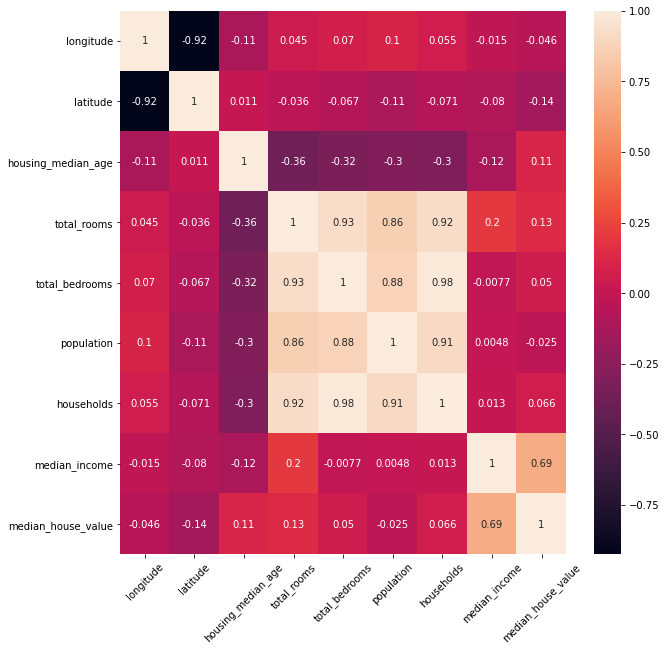

In [5]:
fig, ax = plt.subplots(figsize=(10,10))    
sns.heatmap(df.corr(), annot=True, ax=ax)
plt.xticks(rotation=45);

# 3. Wrangle data

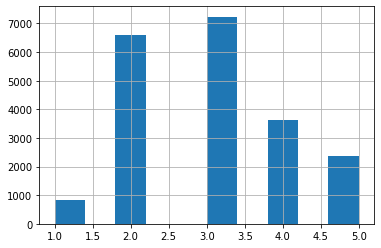

In [6]:
# categorize income (will be used for train/test split)
if "income_cat" not in list(df):
    df.insert(9, "income_cat", 
          pd.cut(df["median_income"],bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5]))

df.income_cat.hist();

# 4. Split training / test data

In [7]:
# perform stratified training/test splitting base on income_cat

splitter = StratifiedShuffleSplit(n_splits = 1, test_size = .2, random_state = 42)

# split data
for train_index, test_index in splitter.split(df, df["income_cat"]):
    strata_train_set = df.loc[train_index] 
    strata_test_set = df.loc[test_index]

# drop income_cat (not useful anymore)
for set_ in (strata_train_set, strata_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
housing = strata_train_set.drop("median_house_value", axis=1)
housing_labels = strata_train_set["median_house_value"].copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


# 5. Preprocess

In [8]:
# store column indexes
rooms_idx, bedrooms_idx, population_idx, households_idx = 3, 4, 5, 6

# transformer to add new attributes
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X):
        
        # compute new features
        rooms_per_household = X[:, rooms_idx] / X[:, households_idx]
        population_per_household = X[:, population_idx] / X[:, households_idx]
        bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
        
        # add features
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    


In [9]:
# create preprocess pipe
preprocess_pipe = Pipeline(
    [
        ("ctransformer", ColumnTransformer([
                ( 
                    "num_pipe", 
                    Pipeline([
                        ("imputer", SimpleImputer(strategy="median")),
                        ("adder", CombinedAttributesAdder()),
                        ("scaler", StandardScaler())
                    ]), 
                    list(housing.select_dtypes(include=[np.number]))
                ),
                ( 
                    "cat_pipe", 
                    Pipeline([
                        ("encoder", OneHotEncoder()),
                    ]), 
                    ["ocean_proximity"])
            ])
        ),
    ]
)

# 6. Estimate model

In [10]:
pipe = Pipeline([
    ("preprocess", preprocess_pipe),
    ("model", RandomForestRegressor())
])

scores = cross_val_score(pipe, housing, housing_labels,
                scoring = "neg_mean_squared_error", cv=10)

rmse_scores = np.sqrt(-scores)

In [11]:
pd.Series(data=rmse_scores).describe()

count       10.000000
mean     50222.518239
std       2067.648989
min      47319.339792
25%      49102.187288
50%      49796.706007
75%      51895.189893
max      53474.293601
dtype: float64

# 7. Fine Tune model

In [12]:
param_grid = [
    {
        "preprocess__ctransformer__num_pipe__imputer__strategy": ["mean","median"],
        "model__n_estimators": [3, 10, 30, 50, 100, 150, 300], "model__max_features": [2,4,6,8]
    }
]

In [13]:
grid_search = GridSearchCV(
    pipe, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score = True)

grid_search.fit(housing, housing_labels);

In [14]:
grid_search.best_params_

{'model__max_features': 6,
 'model__n_estimators': 300,
 'preprocess__ctransformer__num_pipe__imputer__strategy': 'mean'}

# 8. Test model

In [15]:
final_model = grid_search.best_estimator_

X_test = strata_test_set.drop("median_house_value", axis=1)
y_test = strata_test_set["median_house_value"].copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [22]:
final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

46887.74217642702